In [1]:
import math
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import qmc

from glob import glob
import os

from numba import jit
import dask

import regionmask
import matplotlib.pyplot as plt
# import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

In [2]:
#################
## Directories ##
#################
nldas_path = '/storage/group/pches/default/public/NLDAS/'
smap_path = '/storage/group/pches/default/public/SMAP/'
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

## Dask cluster

In [3]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="5GiB",
    walltime="00:10:00",
)

cluster.scale(jobs=5)

In [4]:
# print(cluster.job_script())

In [5]:
from dask.distributed import Client

client = Client(cluster)

client

<Client: 'tcp://10.6.0.12:36011' processes=0 threads=0, memory=0 B>

# Precalibration (central US test case)

## Setup

In [4]:
# Subset to central US
def _subset_centralUS(ds):
    # Define central US
    centralUS_states = ["Illinois", "Iowa", "Wisconsin", "Minnesota", "North Dakota", "South Dakota", "Nebraska", "Kansas", "Missouri", "Indiana", "Ohio", "Michigan", "Kentucky"]
    # Subset
    centralUS_index = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.map_keys(centralUS_states)
    centralUS_mask = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.mask(ds)
    ds_centralUS = ds.where(centralUS_mask.isin(centralUS_index), drop=True)
    # Return
    return ds_centralUS

In [9]:
############################
### Uncertain parameters ###
############################
n_sample = 100_000

if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/params.csv'):
    ###  Define bounds
    # fieldCap range ~ 0 - 0.75 (in m3/m3 -> multiply by 1000 to get mm/m)
    fieldCap_claycoef_lower, fieldCap_claycoef_upper = 0.001, 0.75
    fieldCap_sandcoef_lower, fieldCap_sandcoef_upper = 0.001, 0.75
    fieldCap_siltcoef_lower, fieldCap_siltcoef_upper = 0.001, 0.75

    # wilingp range ~ 0 - 1 (as factor of field capacity)
    wiltingp_claycoef_lower, wiltingp_claycoef_upper = 0.001, 1.
    wiltingp_sandcoef_lower, wiltingp_sandcoef_upper = 0.001, 1.
    wiltingp_siltcoef_lower, wiltingp_siltcoef_upper = 0.001, 1.

    # alpha range ~ 1 - 10
    alpha_claycoef_lower, alpha_claycoef_upper = 0.0, 10.
    alpha_sandcoef_lower, alpha_sandcoef_upper = 0.0, 10.
    alpha_siltcoef_lower, alpha_siltcoef_upper = 0.0, 10.

    # betaHBV range ~ 1 - 10
    betaHBV_claycoef_lower, betaHBV_claycoef_upper = 0.0, 10.
    betaHBV_sandcoef_lower, betaHBV_sandcoef_upper = 0.0, 10.
    betaHBV_siltcoef_lower, betaHBV_siltcoef_upper = 0.0, 10.

    # GS_start_lower, GS_start_upper = 50, 200
    # GS_length_lower, GS_length_upper = 100, 200
    # rootDepth_oGS_lower, rootDepth_oGS_upper = 100, 1200
    # rootDepth_GS_factor_lower, rootDepth_GS_factor_upper = 2., 10.
    # rootDepth_all_lower, rootDepth_all_upper = 100, 2500

    # LHC sampling
    sampler = qmc.LatinHypercube(d=12)
    sample = sampler.random(n=n_sample)

    l_bounds = [fieldCap_claycoef_lower, fieldCap_sandcoef_lower, fieldCap_siltcoef_lower,
                wiltingp_claycoef_lower, wiltingp_sandcoef_lower, wiltingp_siltcoef_lower,
                alpha_claycoef_lower, alpha_sandcoef_lower, alpha_siltcoef_lower,
                betaHBV_claycoef_lower, betaHBV_sandcoef_lower, betaHBV_siltcoef_lower]
    
    u_bounds = [fieldCap_claycoef_upper, fieldCap_sandcoef_upper, fieldCap_siltcoef_upper,
                wiltingp_claycoef_upper, wiltingp_sandcoef_upper, wiltingp_siltcoef_upper,
                alpha_claycoef_upper, alpha_sandcoef_upper, alpha_siltcoef_upper,
                betaHBV_claycoef_upper, betaHBV_sandcoef_upper, betaHBV_siltcoef_upper]

    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

    # Store as csv
    df = pd.DataFrame(data = sample_scaled,
                      columns = ['fieldCap_claycoef', 'fieldCap_sandcoef', 'fieldCap_siltcoef',
                                 'wiltingp_claycoef', 'wiltingp_sandcoef', 'wiltingp_siltcoef',
                                 'alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef',
                                 'betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'])
    df['iparam'] = df.index
    df.to_csv(f'{project_data_path}/WBM/precalibration/centralUS/params.csv', index=False)

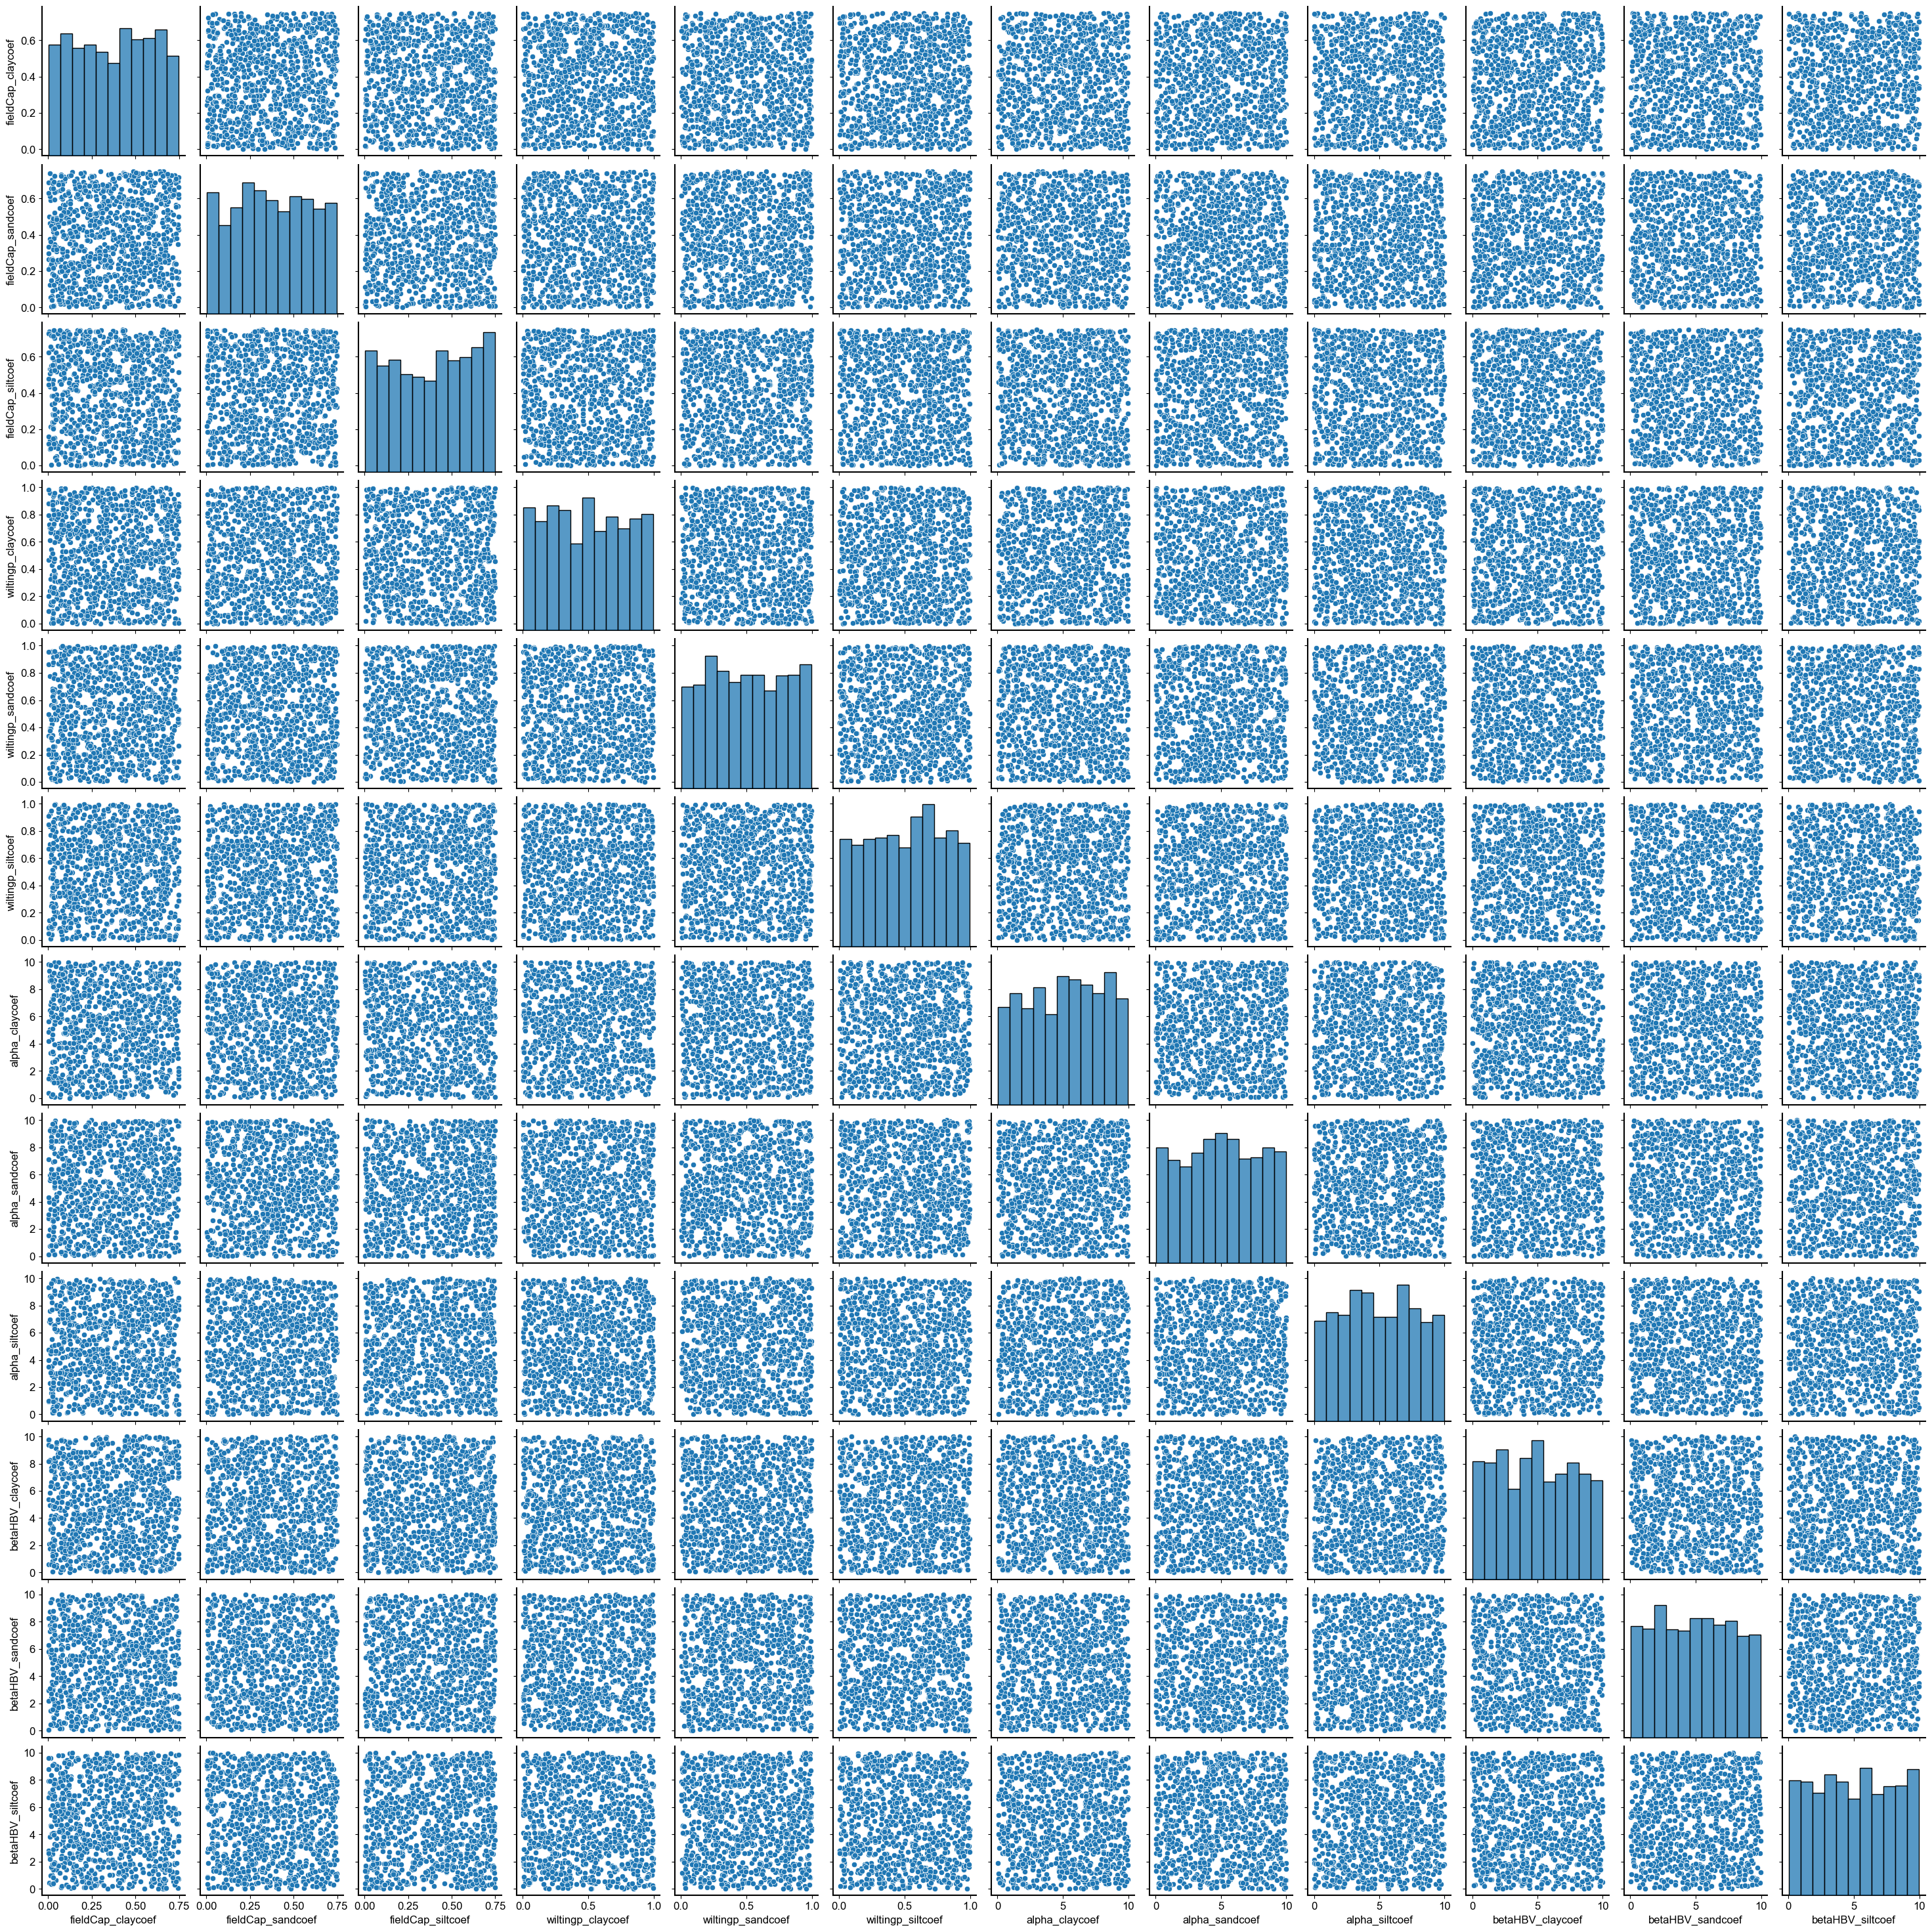

In [17]:
# import seaborn as sns
# sns.pairplot(df.iloc[::100, :-1])

In [18]:
########################################################
########## SMAP and NLDAS data for validation ##########
########################################################
# SMAP
if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc'):
    # Read all
    files = glob(f'{smap_path}/processed_nldas_grid/SMAP_L4_SM_gph_all_nldas_*.nc')
    ds_smap = xr.concat([_subset_centralUS(xr.open_dataset(file)['sm_rootzone']) for file in files], dim='time')
    
    # Merge and store (and change units to kg/m3)
    ds_out = xr.Dataset({'soilMoist':1000*ds_smap})
    # xr.merge([xr.Dataset({'soilMoist_anom':1000*ds_smap_anom})])
    
    ds_out.attrs['units'] = 'kg/m3'
    ds_out.to_netcdf(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc')

    ############################# OLD
    # Use weekly anomalies to validate across different obs
    # ds_smap = ds_smap.assign_coords(week=ds_smap.time.dt.strftime("%W"))
    # ds_smap_anom = (ds_smap.groupby('week') - ds_smap.groupby("week").mean("time"))
    
    # np.save(f'{project_data_path}/WBM/precalibration/centralUS/smap_obs_anoms_weekly.npy',
    #         np.transpose(1000 * ds_smap_anom['sm_rootzone'].to_numpy(), (2,1,0)))

# NLDAS
nldas_dict = {'VIC':'SOILM0_100cm', 'NOAH':'SOILM', 'MOSAIC':'SOILM'}

for model, var_id in nldas_dict.items():
    if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/{model}_validation.nc'):
        # Read all
        files = glob(f'{nldas_path}/{model}/daily/*.nc')
        ds_nldas = xr.concat([_subset_centralUS(xr.open_dataset(file)[var_id]) for file in files], dim='time')
    
        # Select correct depth
        if model in ['MOSAIC', 'NOAH']:
            ds_nldas = ds_nldas.isel(depth=1)
        else:
            ds_nldas = ds_nldas.isel(depth=0)
        
        # Merge and store
        ds_out = xr.Dataset({'soilMoist':ds_nldas})
        # xr.merge([,xr.Dataset({'soilMoist_anom':ds_nldas_anom})])
        
        ds_out.attrs['units'] = 'kg/m3'
        ds_out.to_netcdf(f'{project_data_path}/WBM/precalibration/centralUS/{model}_validation.nc')

        ######################## OLD  
        # Use weekly anomalies to validate across different obs
        # ds_nldas = ds_nldas.assign_coords(week=ds_nldas.time.dt.strftime("%W"))
        # ds_nldas_anom = (ds_nldas.groupby('week') - ds_nldas.groupby("week").mean("time"))
        
        # np.save(f'{project_data_path}/WBM/precalibration/centralUS/{model}_obs_anoms_weekly.npy',
        #         np.transpose(ds_nldas_anom[var_id].to_numpy(), (2,1,0)))

In [40]:
#############################################
### Climate forcing & geoophysical inputs ###
#############################################
if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz'):
    # Climate drivers from NLDAS
    year = '20'
    files = glob(f'{nldas_path}/forcing/daily/NLDAS_FORA0125_H.A{year}*.nc')
    ds_nldas_forcing = _subset_centralUS(xr.concat([xr.open_dataset(file) for file in files], dim='time'))

    # Geophysical inputs
    ds_lai = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/LAI_clima_NLDASgrid.nc'))
    # ds_awCap = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/NLDAS_NOAH_awCap.nc'))
    # ds_wiltingp = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/NLDAS_NOAH_wiltingp.nc'))

    ds_clayfrac = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/clayfrac_NLDASgrid.nc'))
    ds_sandfrac = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/sandfrac_NLDASgrid.nc'))
    ds_siltfrac = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/geo_inputs/siltfrac_NLDASgrid.nc'))

    # Initial conditions
    ds_smap = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc')).isel(time=0)
    ds_noah = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/NOAH_validation.nc')).isel(time=0)
    ds_vic = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/VIC_validation.nc')).isel(time=0)
    ds_mosaic = _subset_centralUS(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/MOSAIC_validation.nc')).isel(time=0)

    ds_soilMoist_init = (ds_smap['soilMoist'] + ds_noah['soilMoist'] + ds_vic['soilMoist'] + ds_mosaic['soilMoist']) / 4.0

    # Numpy arrays in correct order
    lats = ds_lai.lat.to_numpy()
    doy = ds_nldas_forcing.time.dt.dayofyear.to_numpy() - 1

    tas = np.transpose(ds_nldas_forcing['TMP'].to_numpy() - 273.15, (2,1,0))
    prcp = np.transpose(ds_nldas_forcing['APCP'].to_numpy(), (2,1,0))

    lai = np.transpose(ds_lai['LAI'].to_numpy(), (2,1,0))
    # awCap = np.transpose(ds_awCap['awCap'].to_numpy())
    # wiltingp = np.transpose(ds_wiltingp['wiltingp'].to_numpy())

    clayfrac = np.transpose(ds_clayfrac['clayfrac'].to_numpy() / 100) # percentage -> fraction
    sandfrac = np.transpose(ds_sandfrac['sandfrac'].to_numpy() / 100) # percentage -> fraction
    siltfrac = np.transpose(ds_siltfrac['siltfrac'].to_numpy() / 100) # percentage -> fraction

    soilMoist_init = np.transpose(ds_soilMoist_init.to_numpy())

    # Store numpy for easy access
    np.savez(f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz',
             tas=tas, prcp=prcp,
             lai=lai,
             # awCap=awCap, wiltingp=wiltingp,
             lats=lats, doy=doy,
             clayfrac=clayfrac, sandfrac=sandfrac, siltfrac=siltfrac,
             soilMoist_init=soilMoist_init)

## Run ensemble

In [6]:
from numba import njit, prange

################
## Model code ##
################

@njit(parallel=False)
def simulate_water_balance_loop(
    Ws_init,
    Wi_init,
    Sp_init,
    P,
    T,
    Ts,
    Tm,
    rootDepth_oGS,
    rootDepth_GS_factor,
    awCap,
    wilting_point,
    GS_start,
    GS_length,
    lai,
    Kc,
    alpha,
    betaHBV,
    phi,
    doy,
):
    """
    Inputs:
     - Ws_frac_init: initial soil moisture content [mm]
     - Wi_init: initial canopy water storage [mm]
     - Sp_init: initial snowpack [mm]
     - Wg_init: initial groundwater [mm]
     - P: daily precipitation timeseries [mm]
     - T: daily mean temperature timeseries [C]
     - Ts: snowfall threshold [C]
     - Tm: snowmelt threshold [C]
     - rootDepth_oGS: root depth outside the growing season [mm]
     - rootDepth_GS: root depth during the growing season [mm]
     - awCap: available water capacity [mm/m]
     - wilting_point: wilting point [mm]
     - GS_start: planting day / start of growing season []
     - GS_length: length of growing season []
     - Kc: crop scalar factor timeseries []
     - lai: leaf area index timeseries []
     - alpha: drying function scale parameter []
     - betaHBV: HBV direct recharge parameter []
     - phi: latitude [deg]
     - doy: day of year []

    Outputs:
     - Ws: daily soil moisture content timeseries [mm]
     - Ws_frac: daily soil moisture fraction timeseries []
    """
    def calculate_potential_evapotranspiration(T, N, phi):
        """
        Inputs:
         - T: daily mean temperature [C]
         - N: day of year
         - phi: latitude [deg]
        Outputs:
         - daily potential evapotranspiration calculated via the Hamon method [mm]
        Notes: (e.g.) http://data.snap.uaf.edu/data/Base/AK_2km/PET/Hamon_PET_equations.pdf
        """
        
        # Calculate solar declination (delta)
        delta = -23.44 * math.cos(math.radians((360 / 365) * (N + 10)))
        
        # Calculate fractional day length (Lambda)
        Lambda = (1 / math.pi) * math.acos(
            -math.tan(math.radians(phi)) * math.tan(math.radians(delta))
        )
        
        # Calculate saturation vapor pressure
        if T > 0:
            Psat = 0.61078 * np.exp((17.26939 * T) / (T + 237.3))
        else:
            Psat = 0.61078 * np.exp((21.87456 * T) / (T + 265.5))
        
        # Calculate saturation vapor density (rho_sat)    
        rho_sat = (2.167 * Psat) / (T + 273.15)
        
        # Calculate potential evapotranspiration (PET)
        PET = 330.2 * Lambda * rho_sat
        
        return PET

    ##################################
    # Initialization
    ##################################
    # Simulation dimensions
    nx, ny, nt = T.shape
    
    # Soil moisture capacity
    Wcap = np.empty((nx,ny,366))

    # Soil moisture capacity and initial values
    for ix in range(nx):
        for iy in range(ny):
            for t in range(366):
                if (t < GS_start[ix,iy]) or (t > (GS_start[ix,iy] + GS_length[ix,iy])):
                    # outside GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * rootDepth_oGS[ix,iy] / 1000
                else:
                    # during GS
                    Wcap[ix,iy,t] = awCap[ix,iy] * (rootDepth_GS_factor[ix,iy] * rootDepth_oGS[ix,iy]) / 1000

    # Soil moisture [mm]
    Ws = np.empty_like(T)
    Ws[:,:,0] = Ws_init

    # Soil moisture out [mm]
    Ws_out = np.empty_like(T)
    Ws_out[:,:,0] = Ws[:,:,0]

    # # Soil moisture fraction
    # Ws_frac = np.empty_like(T)
    # Ws_frac[:,:,0] = Ws_frac_init
    
    # Canopy water storage
    Wi = np.empty((nx,ny,2))
    Wi[:,:,0] = Wi_init
    
    # Snowpack
    Sp = np.empty((nx,ny,2))
    Sp[:,:,0] = Sp_init

    ######################################
    # Begin simulation
    ######################################
    for ix in range(nx):
        for iy in range(ny):
            for t in range(1, nt):
                # t runs from 1 to n_sim
                # t2 and t2o are 0 or 1 oppositely (used for untracked variables)
                t2 = t % 2
                t2o = int(not(t2))
        
                ################
                # Snowfall
                ################
                # Precipitation is assumed to be entirely snow/rain
                # if temperature is below/above threshold (Ts)
                if T[ix,iy,t] < Ts:
                    Ps = P[ix,iy,t]
                    Pa = 0
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o] + Ps
                else:
                    Pa = P[ix,iy,t]
                    Sp[ix,iy,t2] = Sp[ix,iy,t2o]
        
                ################
                # Snowmelt
                ################
                # Snowmelt is assumed to occur if temperature
                # is above a threshold (Tm), but is limited to
                # the volume of the snowpack
                if T[ix,iy,t] > Tm:
                    Ms = 2.63 + 2.55 * T[ix,iy,t] + 0.0912 * T[ix,iy,t] * Pa
                    if Ms > Sp[ix,iy,t2]:
                        Ms = Sp[ix,iy,t2]
                        Sp[ix,iy,t2] = 0
                    else:
                        Sp[ix,iy,t2] = Sp[ix,iy,t2] - Ms
                else:
                    Ms = 0.0

                #########################
                # Canopy & throughfall
                #########################
                # Maximum canopy storage scales with LAI
                Wi_max = 0.25 * lai[ix,iy,doy[t]]

                # Open water evaporation rate assumed to be PET
                Eow = calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                # Canopy evaporation
                Ec = Eow * ((Wi[ix,iy,t2o] / Wi_max) ** 0.6666667)

                # Throughfall is rainfall minus (canopy storage plus canopy evaporation)
                # Throughfall if zero if all rainfall goes to canopy
                if Wi_max < Pa + Wi[ix,iy,t2o] - Ec:
                    Pt = Pa - Ec - (Wi_max - Wi[ix,iy,t2o])
                else:
                    Pt = 0

                # Update canopy storage
                if Wi[ix,iy,t2o] + (Pa - Pt) - Ec <= Wi_max:
                    if Wi[ix,iy,t2o] + (Pa - Pt) - Ec > 0.0:
                        Wi[ix,iy,t2] = Wi[ix,iy,t2o] + (Pa - Pt) - Ec
                    else:
                        Wi[ix,iy,t2] = 0.0
                else:
                    Wi[ix,iy,t2] = Wi_max

                ########################
                # Evapotranspiration
                ########################
                # Potential ET scales with (annual) crop-specific coefficient
                PET = Kc[ix,iy,doy[t]] * calculate_potential_evapotranspiration(T[ix,iy,t], doy[t], phi[iy])
                
                # Calculate actual evapotranspiration
                # Actual ET is limited by water availability (throughfall + snowmelt)
                # otherwise the difference is scaled by drying function
                if (Pt + Ms) >= PET:
                    AET = PET
                else:
                    g = (1 - np.exp(-alpha[ix,iy] * Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]])) / (1 - np.exp(-alpha[ix,iy]))
                    AET =  g * (PET - Pt - Ms)

                ################
                # Runoff
                ################
                # HBV direct groundwater recharge (can also be thought of as runoff)
                # scales nonlinearly with saturation in the active zone
                # Direct groundwater recharge (HBV)
                Id = (Pt + Ms) * (Ws[ix,iy,t-1] / Wcap[ix,iy,doy[t]]) ** betaHBV[ix,iy]
                
                ################
                # Soil moisture
                ################
                # Soil surplus is the leftover water after saturating soils
                # It gets partitioned to more runoff and groundwater recharge
                if Wcap[ix,iy,doy[t]] < Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET:
                    S = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - Wcap[ix,iy,doy[t]]
                else:
                    S = 0

                # Update soil moisture
                Ws[ix,iy,t] = Ws[ix,iy,t-1] + (Pt + Ms - Id) - AET - S

                # Soil moisture must be positive
                if Ws[ix,iy,t] < 0:
                    Ws[ix,iy,t] = 0.0

                # Wilting point in mm
                # wilting_point_mm = wilting_point[ix,iy] * Wcap[ix,iy,doy[t]]
                
                # Soil wetness
                # Ws_frac[ix,iy,t] = (Ws[ix,iy,t] + wilting_point_mm) / (Wcap[ix,iy,doy[t]] + wilting_point_mm)

                # Soil moisture out (+ wilting point)
                Ws_out[ix,iy,t] = Ws[ix,iy,t] + wilting_point[ix,iy]
    
    # Return
    return Ws_out #, Ws, Wcap, Ms_out, Sp, Pa_out, Ps_out #Wg, AET_out, PET_out, g_out, Sp, Pt_out, Wcap

In [7]:
def run_WBMpy(forcing,
              alpha_claycoef,
              alpha_sandcoef,
              alpha_siltcoef,
              betaHBV_claycoef,
              betaHBV_sandcoef,
              betaHBV_siltcoef,
              Ts,
              Tm,
              Kc,
              fieldCap_claycoef,
              fieldCap_sandcoef,
              fieldCap_siltcoef,
              wiltingp_claycoef,
              wiltingp_sandcoef,
              wiltingp_siltcoef,
              Wi_init,
              Sp_init,
              GS_start,
              GS_length,
              rootDepth_oGS,
              rootDepth_GS_factor,
              iparam,
              store_path,
              simulate_water_balance_loop):
    
    # Read and extract inputs
    npz = np.load(forcing)
    tas_in = npz['tas']
    prcp_in = npz['prcp']
    lai_in = npz['lai']
    lats_in = npz['lats']
    doy_in = npz['doy']
    clayfrac = npz['clayfrac']
    sandfrac = npz['sandfrac']
    siltfrac = npz['siltfrac']
    soilMoist_init = npz['soilMoist_init']
    
    # Setup arrays
    nlon, nlat = Ws_init_in.shape
    
    grid = np.ones((nlon, nlat))

    alpha_in = 1. + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV_in = 1. + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac)

    # field capacity in units of mm/m
    fieldCap = 1000 * ((fieldCap_claycoef * clayfrac) + (fieldCap_sandcoef * sandfrac) + (fieldCap_siltcoef * siltfrac))
    # wilting point is fraction of fieldCap
    wiltingp_in = fieldCap * ((wiltingp_claycoef * clayfrac) + (wiltingp_sandcoef * sandfrac) + (wiltingp_siltcoef * siltfrac))
    # construct awCap such that this relation holds
    awCap_in = fieldCap - wiltingp_in

    # WBM models the active profile so let starting soil moisture reflect this
    Ws_init_in = soilMoist_init - wiltingp_in
    Ws_init_in = np.where(Ws_init_in >= 0., Ws_init_in, 0.)
    
    Kc_in = Kc * np.ones(lai_in.shape)
    Wi_init_in = Wi_init * grid
    Sp_init_in = Sp_init * grid
    GS_start_in = GS_start * grid
    GS_length_in = GS_length * grid
    rootDepth_oGS_in = rootDepth_oGS * grid
    rootDepth_GS_factor_in = rootDepth_GS_factor * grid

    # Run it
    out = simulate_water_balance_loop(
        Ws_init = Ws_init_in,
        Wi_init = Wi_init_in,
        Sp_init = Sp_init_in,
        P = prcp_in,
        T = tas_in,
        Ts = Ts,
        Tm = Tm,
        rootDepth_oGS = rootDepth_oGS_in,
        rootDepth_GS_factor = rootDepth_GS_factor_in,
        awCap = awCap_in,
        wilting_point = wiltingp_in,
        GS_start = GS_start_in,
        GS_length = GS_length_in,
        lai = lai_in,
        Kc = Kc_in,
        alpha = alpha_in,
        betaHBV = betaHBV_in,
        phi = lats_in,
        doy = doy_in
    )

    # Store
    np.save(f'{store_path}/{str(iparam)}.npy', out)

In [8]:
# Run ensemble
df_param = pd.read_csv(f'{project_data_path}/WBM/precalibration/centralUS/params.csv')

# Constants
Ts = -1.             # Snowfall threshold
Tm = 1.              # Snowmelt threshold
Wi_init = 0.         # Initial canopy water storage
Sp_init = 0.         # Initial snowpack

# Neglect influence of growing season for now
GS_start = 0 # meaningless
GS_length = 0 # meaningless
rootDepth_oGS = 1000
rootDepth_GS_factor = 1
Kc = 1

# Dask delayed
delayed = []
for iparam in range(200):
    # Check if done
    if not os.path.isfile(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}.npy'):
        
        # Get uncertain parameters
        alpha_claycoef = df_param[df_param.iparam == iparam]['alpha_claycoef'].values[0]
        alpha_sandcoef = df_param[df_param.iparam == iparam]['alpha_sandcoef'].values[0]
        alpha_siltcoef = df_param[df_param.iparam == iparam]['alpha_siltcoef'].values[0]
        
        betaHBV_claycoef = df_param[df_param.iparam == iparam]['betaHBV_claycoef'].values[0]
        betaHBV_sandcoef = df_param[df_param.iparam == iparam]['betaHBV_sandcoef'].values[0]
        betaHBV_siltcoef = df_param[df_param.iparam == iparam]['betaHBV_siltcoef'].values[0]

        fieldCap_claycoef = df_param[df_param.iparam == iparam]['fieldCap_claycoef'].values[0]
        fieldCap_sandcoef = df_param[df_param.iparam == iparam]['fieldCap_sandcoef'].values[0]
        fieldCap_siltcoef = df_param[df_param.iparam == iparam]['fieldCap_siltcoef'].values[0]

        wiltingp_claycoef = df_param[df_param.iparam == iparam]['wiltingp_claycoef'].values[0]
        wiltingp_sandcoef = df_param[df_param.iparam == iparam]['wiltingp_sandcoef'].values[0]
        wiltingp_siltcoef = df_param[df_param.iparam == iparam]['wiltingp_siltcoef'].values[0]

        # Delayed calculation
        tmp = dask.delayed(run_WBMpy)(
            forcing = f'{project_data_path}/WBM/precalibration/centralUS/centralUS_2016-2022_inputs.npz',
            alpha_claycoef = alpha_claycoef,
            alpha_sandcoef = alpha_sandcoef,
            alpha_siltcoef = alpha_siltcoef,
            betaHBV_claycoef = betaHBV_claycoef,
            betaHBV_sandcoef = betaHBV_sandcoef,
            betaHBV_siltcoef = betaHBV_siltcoef,
            fieldCap_claycoef = fieldCap_claycoef,
            fieldCap_sandcoef = fieldCap_sandcoef,
            fieldCap_siltcoef = fieldCap_siltcoef,
            wiltingp_claycoef = wiltingp_claycoef,
            wiltingp_sandcoef = wiltingp_sandcoef,
            wiltingp_siltcoef = wiltingp_siltcoef,
            Ts = Ts,
            Tm = Tm,
            Kc = Kc,
            Wi_init = Wi_init,
            Sp_init = Sp_init,
            GS_start = GS_start,
            GS_length = GS_length,
            rootDepth_oGS = rootDepth_oGS,
            rootDepth_GS_factor = rootDepth_GS_factor,
            iparam = iparam,
            store_path = f'{project_data_path}/WBM/precalibration/centralUS/out',
            simulate_water_balance_loop = simulate_water_balance_loop
        )

        delayed.append(tmp)

In [9]:
len(delayed)

200

In [ ]:
%%time
# Compute
results = dask.compute(*delayed)

## Analysis

### Calculate metrics

In [3]:
# Get Pearson correlation and RMSE
def calculate_error_metrics(project_data_path, iparam):
    try:
        # Read simulation output
        sim_tmp = np.load(f'{project_data_path}/WBM/precalibration/centralUS/out/{str(iparam)}_Ws.npy')

        # Read SMAP for coords
        smap_obs = xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/SMAP_validation.nc').drop(['soilMoist_anom', 'week'])

        # Construct xr 
        ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=smap_obs.lon,
                lat=smap_obs.lat,
                time=smap_obs.time)
        )

        # Get anomaly from weekly climatology
        ds_sim['soilMoist_clima'] = ds_sim['soilMoist'].groupby(ds_sim.time.dt.isocalendar().week).mean("time")
        ds_sim['soilMoist_anom'] = (ds_sim['soilMoist'].groupby(ds_sim.time.dt.isocalendar().week) - ds_sim['soilMoist_clima'])
        
        smap_obs['soilMoist_clima'] = smap_obs['soilMoist'].groupby(smap_obs.time.dt.isocalendar().week).mean("time")
        smap_obs['soilMoist_anom'] = (smap_obs['soilMoist'].groupby(smap_obs.time.dt.isocalendar().week) - smap_obs['soilMoist_clima'])
        
        # Read other observations
        def calculate_weekly_clima(ds):
            ds_tmp = ds.copy().drop(['soilMoist_anom', 'week'])
            ds_tmp['soilMoist_clima'] = ds_tmp['soilMoist'].groupby(ds_tmp.time.dt.isocalendar().week).mean("time")
            ds_tmp['soilMoist_anom'] = (ds_tmp['soilMoist'].groupby(ds_tmp.time.dt.isocalendar().week) - ds_tmp['soilMoist_clima'])
            return ds_tmp
            
        noah_obs = calculate_weekly_clima(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/NOAH_validation.nc'))
        vic_obs = calculate_weekly_clima(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/VIC_validation.nc'))
        mosaic_obs = calculate_weekly_clima(xr.open_dataset(f'{project_data_path}/WBM/precalibration/centralUS/MOSAIC_validation.nc'))

        # Person correlation
        # smap_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), smap_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')
        # vic_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), vic_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')
        # mosaic_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), mosaic_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')
        # noah_corr = xr.corr(ds_sim['soilMoist'].isel(time=slice(100,3000)), noah_obs['soilMoist'].isel(time=slice(100,3000)), dim='time')

        # smap_corr = xr.corr(ds_sim['soilMoist_clima'], smap_obs['soilMoist_clima'], dim='time')
        # vic_corr = xr.corr(ds_sim['soilMoist_clima'], vic_obs['soilMoist_clima'], dim='time')
        # mosaic_corr = xr.corr(ds_sim['soilMoist_clima'], mosaic_obs['soilMoist_clima'], dim='time')
        # noah_corr = xr.corr(ds_sim['soilMoist_clima'], noah_obs['soilMoist_clima'], dim='time')
        
        smap_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), smap_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')
        vic_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), vic_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')
        mosaic_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), mosaic_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')
        noah_corr_anom = xr.corr(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), noah_obs['soilMoist_anom'].isel(time=slice(100,3000)), dim='time')

        # RMSE
        def _calculate_rmse(ds1, ds2):
            return np.sqrt(((ds1 - ds2)**2).mean(dim='week'))

        # smap_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), smap_obs['soilMoist'].isel(time=slice(100,3000)))
        # vic_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), vic_obs['soilMoist'].isel(time=slice(100,3000)))
        # mosaic_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), mosaic_obs['soilMoist'].isel(time=slice(100,3000)))
        # noah_rmse = _calculate_rmse(ds_sim['soilMoist'].isel(time=slice(100,3000)), noah_obs['soilMoist'].isel(time=slice(100,3000)))

        smap_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], smap_obs['soilMoist_clima'])
        vic_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], vic_obs['soilMoist_clima'])
        mosaic_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], mosaic_obs['soilMoist_clima'])
        noah_rmse = _calculate_rmse(ds_sim['soilMoist_clima'], noah_obs['soilMoist_clima'])
        
        # smap_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), smap_obs['soilMoist_anom'].isel(time=slice(100,3000)))
        # vic_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), vic_obs['soilMoist_anom'].isel(time=slice(100,3000)))
        # mosaic_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), mosaic_obs['soilMoist_anom'].isel(time=slice(100,3000)))
        # noah_rmse_anom = _calculate_rmse(ds_sim['soilMoist_anom'].isel(time=slice(100,3000)), noah_obs['soilMoist_anom'].isel(time=slice(100,3000)))

        # Merge all
        ds_out = xr.Dataset({
            # 'smap_pearsonr': smap_corr,
            'smap_pearsonr_anom': smap_corr_anom,
            # 'vic_pearsonr': vic_corr,
            'vic_pearsonr_anom': vic_corr_anom,
            # 'noah_pearsonr': noah_corr,
            'noah_pearsonr_anom': noah_corr_anom,
            # 'mosaic_pearsonr': mosaic_corr,
            'mosaic_pearsonr_anom': mosaic_corr_anom,
            'smap_rmse_clima': smap_rmse,
            # 'smap_rmse_anom': smap_rmse_anom,
            'vic_rmse_clima': vic_rmse,
            # 'vic_rmse_anom': vic_rmse_anom,
            'noah_rmse_clima': noah_rmse,
            # 'noah_rmse_anom': noah_rmse_anom,
            'mosaic_rmse_clima': mosaic_rmse,
            # 'mosaic_rmse_anom': mosaic_rmse_anom,
        })
        
        # Return spatial average
        return ds_out.mean(dim=['lat','lon']).assign_coords(iparam=[iparam]).to_dataframe()
            
    except Exception as e:
         with open(f'/storage/work/dcl5300/current_projects/wbm_soilM_crop_uc_lafferty-etal-2024-tbd/code/logs/{str(iparam)}.txt', 'w') as f:
            f.write(str(e))
            return None

In [7]:
# Delayed
delayed = []

for iparam in range(10_000):
    tmp = dask.delayed(calculate_error_metrics)(project_data_path = project_data_path,
                                                iparam = iparam)
    delayed.append(tmp)

In [ ]:
%%time
# Compute
out = dask.compute(*delayed)

# Store
pd.concat(out).to_csv(f'{project_data_path}/WBM/precalibration/centralUS/results_2step.csv')